In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors, ensemble, kernel_ridge, svm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn import neighbors, ensemble, kernel_ridge, svm

## Load data

In [187]:
# Ignore ORIGIN_CALL and other categorical columns
np.random.seed(42)
# train_arr = np.loadtxt("../data/numeric_trainvf.csv", dtype=np.float32, delimiter=",", skiprows=1)[:, 4:]
df_train = pd.read_csv("../data/combined_trainvf_trig.csv", index_col=0)
df_train.head()

# Prune
mean = df_train["TARGET"].mean()
std = df_train["TARGET"].std()

df_train = df_train[df_train["DIST"] < 20]
df_train = df_train[df_train["TARGET"] > 30]
df_train = df_train[df_train["TARGET"] < 15000]
# for i in ["START_LAT", "START_LONG", "DIST"]:
#     df_train.loc[df_train["A"] == 1, i] = 0
#     df_train.loc[df_train["C"] == 1, i] = 0

# Categorical
cat_list = ["ORIGIN_CALL", "ORIGIN_STAND", "TAXI_ID"]
df_train[cat_list] = df_train[cat_list].astype("category")


# Test
# test = np.loadtxt("../data/combined_testvf.csv", delimiter=",", skiprows=1)[:, 3:]
df_test = pd.read_csv("../data/combined_testvf_trig.csv")
for col in cat_list:
    df_test[col] = df_test[col].astype("category").cat.set_categories(df_train[col].cat.categories)

droplist = []


# for i in ["START_LAT", "START_LONG", "DIST"]:
#     df_test.loc[df_test["A"] == 1, i] = 0
#     df_test.loc[df_test["C"] == 1, i] = 0
# Split
df_test.drop(labels=droplist, inplace=True, axis=1)
df_train.drop(labels=droplist, inplace=True, axis=1)

train, valid = train_test_split(df_train, test_size=0.1)
train_label = train["TARGET"]
# train.drop(labels=["TARGET"], inplace=True, axis=1)
valid_label = valid["TARGET"]
valid.drop(labels=["TARGET"], inplace=True, axis=1)

/tmp/ipykernel_103/1083328072.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.drop(labels=["TARGET"], inplace=True, axis=1)


In [149]:
df_pred = pd.read_csv("../data/sampleSubmission.csv")
df_pred["TRAVEL_TIME"] = preds_cmb
df_pred.to_csv("./combined_xgboost100_snapshot.csv", index=False)

In [6]:
def score(model):
    pred = model.predict(valid)
    print(f"RMSE: {np.sqrt(np.sum((pred - valid_label)**2) / len(valid))}")

## Models

### XGBoost

### Best validation model

In [13]:
xgb_w = xgb.XGBRegressor(tree_method="gpu_hist", 
                            booster="dart",
                            n_estimators=100, 
                            enable_categorical=True, 
                            max_cat_to_onehot=100,
                            objective="reg:gamma")
xgb_w.fit(train[['ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'START_LONG', 'START_LAT',
       'A', 'B', 'C', 'YEAR', 'WK_OF_YR', 'WK_DAY', 'MONTH', 'DAY', 'HR',
       'DIST', 'WK_OF_YR_SIN', 'WK_OF_YR_COS', 'WK_DAY_SIN', 'WK_DAY_COS',
       'MONTH_SIN', 'MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HR_SIN', 'HR_COS']], train["TARGET"], sample_weight=train["TARGET"])
preds_xgbw = xgb_w.predict(df_test)
score(xgb_w)

RMSE: 679.4278890032107


In [88]:
xgb_u = xgb.XGBRegressor(tree_method="gpu_hist", 
                            booster="dart",
                            n_estimators=100, 
                            enable_categorical=True, 
                            max_cat_to_onehot=100,
                            objective="reg:gamma")
xgb_u.fit(train[['ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'START_LONG', 'START_LAT',
       'A', 'B', 'C', 'YEAR', 'WK_OF_YR', 'WK_DAY', 'MONTH', 'DAY', 'HR',
       'DIST', 'WK_OF_YR_SIN', 'WK_OF_YR_COS', 'WK_DAY_SIN', 'WK_DAY_COS',
       'MONTH_SIN', 'MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HR_SIN', 'HR_COS']], train["TARGET"])
preds_xgbu = xgb_u.predict(df_test)
score(xgb_u)

RMSE: 549.3118877097091


In [192]:
spec_df = []
# August
spec_df.append(df_train[(df_train["HR"] < 12)])
xgb_aug = xgb.XGBRegressor(tree_method="gpu_hist", 
                            booster="dart",
                            n_estimators=100, 
                            enable_categorical=True, 
                            max_cat_to_onehot=100,
                            objective="reg:gamma")
xgb_aug.fit(spec_df[-1][['ORIGIN_CALL','ORIGIN_STAND', 'TAXI_ID', 'START_LONG', 'START_LAT',
       'A', 'B', 'C', 'YEAR', 'WK_OF_YR', 'WK_DAY', 'MONTH', 'DAY', 'HR',
       'DIST', 'WK_OF_YR_SIN', 'WK_OF_YR_COS', 'WK_DAY_SIN', 'WK_DAY_COS',
       'MONTH_SIN', 'MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HR_SIN', 'HR_COS']], spec_df[-1]["TARGET"],
           sample_weight= spec_df[-1]["TARGET"])
preds_aug = xgb_aug.predict(df_test[df_test["MONTH"] == 8])


# September
spec_df.append(df_train[(df_train["WK_OF_YR"] >= 38) & (df_train["WK_OF_YR"] <= 42) & ((df_train["HR"] > 22) | df_train["HR"] < 4)])
xgb_sep = xgb.XGBRegressor(tree_method="gpu_hist", 
                            booster="dart",
                            n_estimators=100, 
                            enable_categorical=True, 
                            max_cat_to_onehot=100,
                            objective="reg:gamma")
xgb_sep.fit(spec_df[-1][['ORIGIN_CALL','ORIGIN_STAND', 'TAXI_ID', 'START_LONG', 'START_LAT',
       'A', 'B', 'C', 'YEAR', 'WK_OF_YR', 'WK_DAY', 'MONTH', 'DAY', 'HR',
       'DIST', 'WK_OF_YR_SIN', 'WK_OF_YR_COS', 'WK_DAY_SIN', 'WK_DAY_COS',
       'MONTH_SIN', 'MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HR_SIN', 'HR_COS']], spec_df[-1]["TARGET"], 
            sample_weight=spec_df[-1]["TARGET"])
preds_sep = xgb_sep.predict(df_test[(df_test["WK_OF_YR"] == 40)])


# Early october
spec_df.append(df_train[(df_train["HR"] < 12)])
xgb_oct = xgb.XGBRegressor(tree_method="gpu_hist", 
                            booster="dart",
                            n_estimators=100, 
                            enable_categorical=True, 
                            max_cat_to_onehot=100,
                            objective="reg:gamma")
xgb_oct.fit(spec_df[-1][['ORIGIN_CALL','ORIGIN_STAND', 'TAXI_ID', 'START_LONG', 'START_LAT',
       'A', 'B', 'C', 'YEAR', 'WK_OF_YR', 'WK_DAY', 'MONTH', 'DAY', 'HR',
       'DIST', 'WK_OF_YR_SIN', 'WK_OF_YR_COS', 'WK_DAY_SIN', 'WK_DAY_COS',
       'MONTH_SIN', 'MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HR_SIN', 'HR_COS']], spec_df[-1]["TARGET"],
           sample_weight=spec_df[-1]["TARGET"])
preds_oct = xgb_oct.predict(df_test[(df_test["WK_OF_YR"] == 41)])

# Halloween
preds_hal = xgb_u.predict(df_test[(df_test["WK_OF_YR"] == 44)])

# Christmas one
spec_df.append(df_train[(df_train["MONTH"] == 12) & (df_train["DAY"] > 18)])
xgb_x = xgb.XGBRegressor(tree_method="gpu_hist", 
                            booster="dart",
                            n_estimators=100, 
                            enable_categorical=True, 
                            max_cat_to_onehot=100,
                            objective="reg:gamma")
xgb_x.fit(spec_df[0][['ORIGIN_CALL','ORIGIN_STAND', 'TAXI_ID', 'START_LONG', 'START_LAT',
       'A', 'B', 'C', 'YEAR', 'WK_OF_YR', 'WK_DAY', 'MONTH', 'DAY', 'HR',
       'DIST', 'WK_OF_YR_SIN', 'WK_OF_YR_COS', 'WK_DAY_SIN', 'WK_DAY_COS',
       'MONTH_SIN', 'MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HR_SIN', 'HR_COS']], spec_df[0]["TARGET"])
preds_xgbx = xgb_x.predict(df_test[df_test["MONTH"] == 12])

preds_cmb = np.zeros(320)
preds_cmb[df_test["WK_OF_YR"] == 51] = preds_xgbx
preds_cmb[df_test["WK_OF_YR"] == 33] = preds_aug
preds_cmb[df_test["WK_OF_YR"] == 40] = preds_sep
preds_cmb[df_test["WK_OF_YR"] == 41] = preds_oct
preds_cmb[df_test["WK_OF_YR"] == 44] = preds_hal

In [190]:
xgb_u.save_model("best_validation.json")
xgb_w.save_model("best_validation_weighted.json")
xgb_x.save_model("best_christmas.json")
xgb_oct.save_model("early_oct.json")
xgb_sep.save_model("best_sep.json")
xgb_aug.save_model("bset_aug.json")

In [191]:
df_pred = pd.read_csv("../data/sampleSubmission.csv")
df_pred["TRAVEL_TIME"] = preds_cmb
df_pred.to_csv("./combined_xgboost100_snapshot2.csv", index=False)

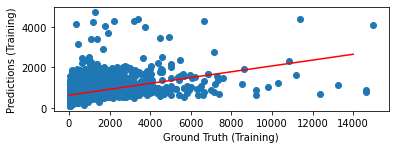

In [26]:
train_sample = train.sample(n=20000)
plt.gca().set_aspect('equal')
preds_t_xgbu = xgb_u.predict(train_sample[['ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'START_LONG', 'START_LAT',
       'A', 'B', 'C', 'YEAR', 'WK_OF_YR', 'WK_DAY', 'MONTH', 'DAY', 'HR',
       'DIST', 'WK_OF_YR_SIN', 'WK_OF_YR_COS', 'WK_DAY_SIN', 'WK_DAY_COS',
       'MONTH_SIN', 'MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HR_SIN', 'HR_COS']])
line = LinearRegression()
line.fit(train_sample["TARGET"].to_numpy().reshape(-1, 1), preds_t_xgbu)

plt.plot(np.arange(0, 14000), line.predict(np.arange(0, 14000).reshape(-1,1)), color="red")
plt.scatter(train_sample["TARGET"], preds_t_xgbu)
plt.xlabel("Ground Truth (Training)")
plt.ylabel("Predictions (Training)")
plt.show()

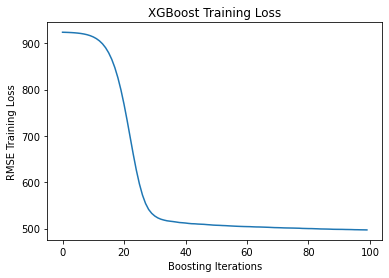

In [150]:
plt.xlabel("Boosting Iterations")
plt.ylabel("RMSE Training Loss")
plt.title("XGBoost Training Loss")
plt.plot(xgb_u.evals_result()["validation_0"]["rmse"])
plt.show()


In [103]:
xgbu_train = xgb_u.predict(train)

In [80]:
xgb_f = xgb.XGBRegressor(tree_method="gpu_hist", 
                              n_estimators=800, 
                              enable_categorical=True, 
                              max_cat_to_onehot=100,
                              learning_rate=0.01,
                              objective="reg:gamma",
#                               sampling_method="gradient_based",
                              subsample=0.5,
                              )
xgb_f.fit(train, train_label)
preds_xgbf = xgb_f.predict(df_test)
score(xgb_f)

RMSE: 597.3936079632348


In [129]:
df_pred = pd.read_csv("../data/sampleSubmission.csv")
df_pred["TRAVEL_TIME"] = preds_xgbu
df_pred.to_csv("./combined_xgboost100_max10k_gamma.csv", index=False)

In [75]:
xgb_f = xgb.XGBRegressor(tree_method="gpu_hist", 
                            booster="dart",
                            n_estimators=100, 
                            enable_categorical=True, 
                            max_cat_to_onehot=400,
                            max_cat_threshold=100,
                            subsample=0.5,
                            colsample_bytree=0.5,
#                             learning_rate=0.01,
                            objective="reg:gamma"
                        )
xgb_f.fit(train, train_label, 
          sample_weight=np.sqrt(train_label), 
         )
preds_xgbf = xgb_f.predict(df_test)
score(xgb_f)

RMSE: 571.1466201616595


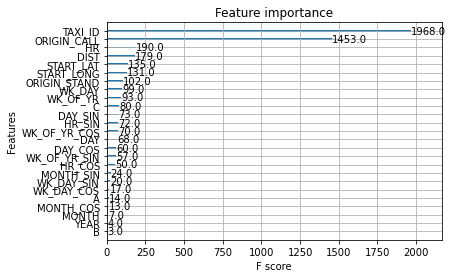

In [173]:
xgb.plot_importance(xgb_u)
plt.show()

In [78]:
df_pred = pd.read_csv("../data/sampleSubmission.csv")
df_pred["TRAVEL_TIME"] = preds_xgbf
df_pred.to_csv("./combined_xgboost_xgbf.csv", index=False)

In [73]:
stack = ensemble.StackingRegressor(estimators=[('u', xgb_u), ('w', xgb_w)], 
                                   final_estimator=xgb.XGBRegressor(tree_method="gpu_hist"),
#                                    n_jobs=-1,
                                   passthrough=True)
stack.fit(train, train_label)
score(stack)

RMSE: 539.9471300235914


In [190]:
stack_w = ensemble.StackingRegressor(estimators=[('u', xgb_u), ('w', xgb_w)], 
                                   final_estimator=xgb.XGBRegressor(tree_method="gpu_hist"),
                                   n_jobs=-1,
                                   passthrough=True)
stack_w.fit(train, train_label, sample_weight=train_label)
score(stack_w)

RMSE: 696.7636183988395


In [191]:
preds_stackw = stack_w.predict(df_test)

In [159]:
m = np.mean(preds_xgbu)
s = np.std(preds_xgbu)
preds_comb = preds_xgbu.copy()
preds_comb[preds_xgbu > m] = preds_xgbw[preds_xgbu > m]

In [160]:
preds_mean = preds_xgbw + preds_xgbu / 2

In [161]:
df_pred = pd.read_csv("../data/sampleSubmission.csv")
df_pred["TRAVEL_TIME"] = preds_comb
df_pred.to_csv("./combined_xgboost100_gamma_staple.csv", index=False)

In [194]:
print(np.std(preds_xgbu))
print(np.std(preds_xgbw))
print(np.std(preds_comb))
print(np.std(preds_mean))
print(np.std(preds_stack))
print(np.std(preds_stackw))

255.47655
541.30066
616.3682
652.86163
353.0005
644.54144


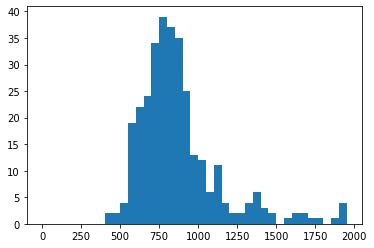

In [22]:
plt.hist(preds_xgbu, bins=np.arange(0,2000, 50))
plt.show()

In [54]:
preds = reg.predict(df_test) # No taxi id, origin call, origin stand, no coords
df_pred = pd.read_csv("../data/sampleSubmission.csv")
df_pred["TRAVEL_TIME"] = preds
df_pred.to_csv("./combined_xgboost_all_5_default_15kmax_TRIG.csv", index=False)

## Create prediction csv

In [9]:
df_pred["TRAVEL_TIME"] = preds
df_pred.to_csv("./combined_xgboost_4_all_notimecategories.csv", index=False)